In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from scipy import linalg, stats
from scipy.sparse.linalg import svds
from sklearn.datasets import fetch_openml

# Load dataset

In [2]:
# Load Fashion-MNIST
fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
X_full = np.array(fashion_mnist.data).T/255
y_full = np.array(fashion_mnist.target).astype(int)

In [3]:
# Sort by class
idx = np.argsort(y_full)
X_full, y_full = X_full[:, idx], y_full[idx]

In [4]:
# Get dimensions
p, N = X_full.shape
n = 2*N//10 # number of samples for a two-class problem
c = p/n

# Define indicator of classes
y = np.ones(n, dtype=int)/np.sqrt(n)
y[:n//2] *= -1

# Spike computation

In [5]:
def get_spike(k1, k2):
    # Select data
    mask = (y_full == k1) | (y_full == k2)
    X = X_full[:, mask]
    # Compute spike eigenvectors
    _, _, Vt = svds(X/np.sqrt(p), k=1, which='LM') # using SVD avoids computing the kernel matrix (costly)
    v = Vt[0]-np.mean(Vt[0]) # center
    v /= linalg.norm(v) # renormalize
    v = -v if v@y < 0 else v # sign correction
    return v

# An example: Trouser vs. Ankle boot

In [6]:
v = get_spike(1, 9)
zeta = np.mean(n*v*y)**2 # estimation of zeta given y

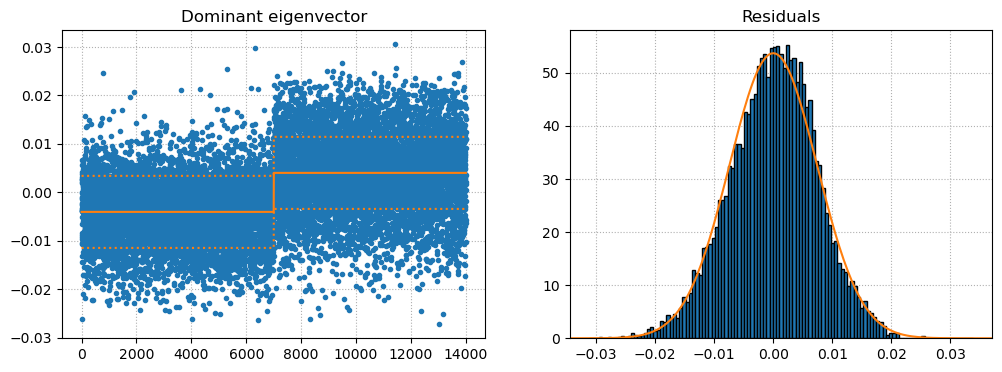

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(v, ls='', marker='.', color='C0')
ax[0].plot(np.sqrt(zeta)*y, color='C1')
ax[0].plot(np.sqrt(zeta)*y+np.sqrt((1-zeta)/n), ls=':', color='C1')
ax[0].plot(np.sqrt(zeta)*y-np.sqrt((1-zeta)/n), ls=':', color='C1')
ax[0].grid(ls=':')
ax[0].set_title("Dominant eigenvector")

ax[1].hist(v-np.sqrt(zeta)*y, density=True, bins='sqrt', edgecolor='black', zorder=2)
xmin, xmax = ax[1].get_xlim()
xx = np.linspace(xmin, xmax, 200)
yy = stats.norm.pdf(xx, loc=0, scale=np.sqrt((1-zeta)/n))
ax[1].plot(xx, yy)
ax[1].set_xlim(xmin, xmax)
ax[1].grid(ls=':')
ax[1].set_title("Residuals")

plt.show()

# Classification accuracy over all combinations

In [8]:
acc_th = np.zeros((10, 10)) # predicted accuracy
acc_ex = np.zeros((10, 10)) # observed accuracy

for k1, k2 in tqdm(list(combinations(range(10), 2))):
    v = get_spike(k1, k2)
    zeta = np.mean(n*v*y)**2 # estimation of zeta given y
    acc_th[k1, k2] = stats.norm.cdf(np.sqrt(zeta/(1-zeta)))
    y_est = np.sign(v)
    acc_ex[k1, k2] = np.mean(y_est*y > 0)

100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


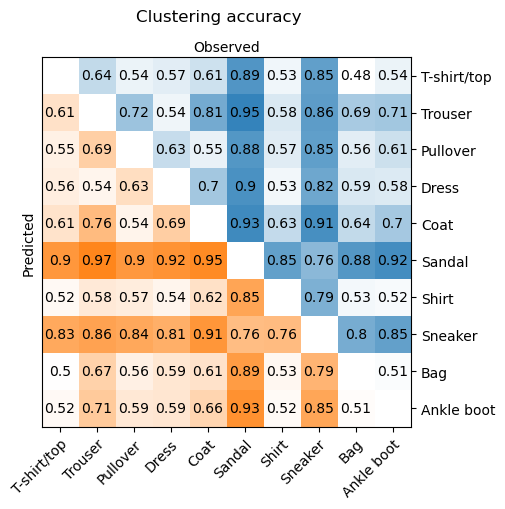

In [9]:
fig, ax = plt.subplots()
ax.imshow(np.ma.masked_array(acc_ex, acc_ex < .5), vmin=.5, vmax=1, cmap=LinearSegmentedColormap.from_list("mycmap", ['white', 'C0']))
ax.imshow(np.ma.masked_array(acc_th, acc_th < .5).T, vmin=.5, vmax=1, cmap=LinearSegmentedColormap.from_list("mycmap", ['white', 'C1']))
ax.set_xticks(np.arange(10), labels=classes, rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticks(np.arange(10), labels=classes)
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
for k1, k2 in combinations(range(10), 2):
    ax.text(k1, k2, np.round(acc_th[k1, k2], 2), ha='center', va='center')
    ax.text(k2, k1, np.round(acc_ex[k1, k2], 2), ha='center', va='center')
fig.suptitle("Clustering accuracy")
plt.show()